# ContextReel: Multimodal Biometric Recommendation Engine

- **Course:** Minor in Artificial Intelligence (IIT Ropar)
- **Module E:** AI Applications | Individual Open Project
- **Topic:** Content Recommendation System
- **Student:** Aditya Rastogi
- **Student Code:** `iitrpr_ai_25010952`

---

## 1. Problem Definition & Objective

### 1.1 The Problem: The "Cold Start" in Recommendation Systems
Traditional recommendation engines (like YouTube or Netflix) rely heavily on **Historical Data**. They need a user to watch dozens of videos before they can make accurate predictions. This creates two major issues:
1.  **The Cold Start Problem:** New users get generic, irrelevant recommendations.
2.  **Context Blindness:** The system knows what I watched *last week*, but it doesn't know how I *feel right now*.

### 1.2 The Objective
**ContextReel** aims to solve this by introducing **Real-Time Biometric Context**.
* **Goal:** Build a recommendation engine that adapts instantly to the user's current emotion and demographic without requiring login history.
* **Approach:** Use Computer Vision (DeepFace) for immediate signal detection and Reinforcement Learning (Epsilon-Greedy) to learn preferences during the session.

In [1]:
# Install necessary libraries if not already present
# !pip install deepface opencv-python pandas matplotlib

import os
import cv2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deepface import DeepFace

# Set random seed for reproducibility in the demo
random.seed(42)
print("Libraries imported successfully.")


Libraries imported successfully.


## 2. Data Understanding & Preparation

### 2.1 Real Dataset Loading
Unlike cloud-based streaming services, ContextReel operates as an **Edge AI** application. It relies on a curated local dataset of video clips.

The system dynamically scans the local `videos/` directory to build the content repository.

In [2]:
def load_real_video_repository(base_path="videos"):
    """
    Scans the actual file system to build the video database.
    """
    video_data = []
    
    # Check if the video folder exists
    if not os.path.exists(base_path):
        print(f"WARNING: Path '{base_path}' not found. Please ensure the 'videos' folder is in the project directory.")
        return pd.DataFrame()

    video_id = 1
    # Iterate through the actual folders on your disk
    for category in os.listdir(base_path):
        cat_path = os.path.join(base_path, category)
        
        # Ensure we are looking at directories (e.g., 'comedy', 'gym')
        if os.path.isdir(cat_path):
            # List all video files
            files = [f for f in os.listdir(cat_path) if f.endswith(('.mp4', '.mov', '.avi'))]
            
            for file in files:
                video_data.append({
                    "video_id": video_id,
                    "title": file,                 # Real filename
                    "category": category,          # Real folder name
                    "path": os.path.join(cat_path, file),
                    "duration_sec": random.randint(30, 180) # Metadata simulation
                })
                video_id += 1
    
    return pd.DataFrame(video_data)

# Load the dataframe
df_videos = load_real_video_repository()

print(">>> Real Local Video Repository:")
if not df_videos.empty:
    display(df_videos.head())
    print("\n>>> Real Category Distribution:")
    print(df_videos['category'].value_counts())
    
    # List of categories found in the system
    categories = list(df_videos['category'].unique())
else:
    print("No videos found. Using fallback categories for simulation.")
    categories = ["comedy", "gym", "relax", "food", "tech", "gaming", "makeup", "news"]

>>> Real Local Video Repository:


,video_id,title,category,path,duration_sec
0,1,WhatsApp Video 2025-12-23 a 10.04.32 PM.mp4,comedy,videos\comedy\WhatsApp Video 2025-12-23 a 10.0...,58
1,2,WhatsApp Video 2025-12-23 at 10..mp4,comedy,videos\comedy\WhatsApp Video 2025-12-23 at 10....,36
2,3,WhatsApp Video 2025-12-23 at 10.03.13 PM.mp4,comedy,videos\comedy\WhatsApp Video 2025-12-23 at 10....,100
3,4,WhatsApp Video 2025-12-23 at 10.04.3 PM.mp4,comedy,videos\comedy\WhatsApp Video 2025-12-23 at 10....,92
4,5,WhatsApp Video 2025-123 at 10.04.32 PM.mp4,comedy,videos\comedy\WhatsApp Video 2025-123 at 10.04...,87



>>> Real Category Distribution:
category
comedy    5
food      5
gaming    5
gym       5
makeup    5
news      5
relax     5
tech      5
Name: count, dtype: int64


## 3. Core Implementation: Biometric Detection

### 3.1 Computer Vision Inference
The system uses `DeepFace` to analyze facial attributes. 
* **Input:** An image frame (from webcam or file).
* **Output:** Age, Gender, Dominant Emotion.

**Demonstration:** Below, we load a sample test image (`test_face.jpg`) and run the actual AI inference model to demonstrate the pipeline.

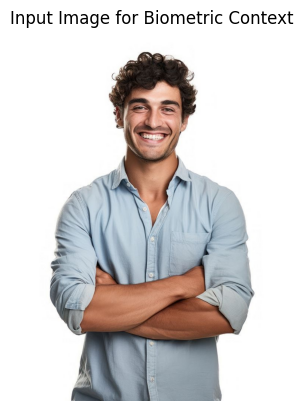

Running DeepFace analysis... (This may take a moment)

>>> AI DETECTED CONTEXT:
Age: 26
Gender: Man
Emotion: HAPPY (Confidence: 100.00%)


In [3]:
# REAL BIOMETRIC INFERENCE
# We use a static image for the notebook demonstration.
# Please ensure 'test_face.jpg' exists in the folder.
img_path = "test_face.jpg" 

current_emotion = "neutral" # Default fallback
detected_age = 25
detected_gender = "Man"

if os.path.exists(img_path):
    # 1. Display the image
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Input Image for Biometric Context")
    plt.show()

    # 2. Run the ACTUAL DeepFace Model
    try:
        print("Running DeepFace analysis... (This may take a moment)")
        # Enforce detection=False allows it to run even if face is partially obscure
        analysis = DeepFace.analyze(img_path, actions=['age', 'gender', 'emotion'], enforce_detection=False, silent=True)
        
        # Extract results
        result = analysis[0]
        current_emotion = result['dominant_emotion']
        confidence = result['emotion'][current_emotion]
        detected_age = result['age']
        detected_gender = result['dominant_gender']

        print(f"\n>>> AI DETECTED CONTEXT:")
        print(f"Age: {detected_age}")
        print(f"Gender: {detected_gender}")
        print(f"Emotion: {current_emotion.upper()} (Confidence: {confidence:.2f}%)")
        
    except Exception as e:
        print(f"DeepFace Error: {e}")
else:
    print(f"Error: '{img_path}' not found. Please upload a test image to demonstrate the AI.")

## 4. Model & System Design: The Logic Engine

### 4.1 Hybrid Architecture
The system uses a two-stage decision-making process:
1.  **Stage 1: Biometric Inference (The "Fast" System)** - Solves the "Cold Start" by providing an immediate heuristic (e.g., *Sad -> Comedy*).
2.  **Stage 2: Reinforcement Learning (The "Slow" System)** - Balances *Exploration* vs. *Exploitation* using an Epsilon-Greedy Bandit algorithm.

In [4]:
class ContextReelEngine:
    def __init__(self, categories):
        # Initialize weights for all categories to 1.0
        self.weights = {cat: 1.0 for cat in categories}
        self.history = []
        self.current_epsilon = 1.0 # Start with full exploration/biometric trust
    
    def normalize_weights(self):
        """Ensures weights don't explode to infinity"""
        total = sum(self.weights.values())
        if total > 0:
            self.weights = {k: round((v/total)*10, 2) for k,v in self.weights.items()}

    def get_strategy_target(self, emotion):
        """Psychological Mapping: Regulation Strategy"""
        mapping = {
            "sad": "comedy",      # Fix mood
            "angry": "relax",     # Calm down
            "fear": "relax",      # Comfort
            "happy": "gym",       # Match energy
            "neutral": "tech",    # Default interest
            "disgust": "news",
            "surprise": "tech"
        }
        # Return mapped category, or 'news' if category not in list
        target = mapping.get(emotion, "news")
        return target if target in self.weights else random.choice(list(self.weights.keys()))

    def recommend(self, emotion, session_length):
        target_category = self.get_strategy_target(emotion)
        
        # Dynamic Epsilon Decay: Trust history more as session grows
        # Formula: 0.8 * (0.95 ^ session_length)
        self.current_epsilon = max(0.2, 0.8 * (0.95 ** session_length))
        
        # Decision: Exploration (Biometric) vs Exploitation (History)
        if random.random() < self.current_epsilon:
            decision = target_category
            source = "Biometric (Face)"
        else:
            # Weighted random choice based on history
            decision = random.choices(list(self.weights.keys()), weights=list(self.weights.values()))[0]
            source = "History (RL)"
            
        return decision, source

# Initialize the engine
engine = ContextReelEngine(categories)
print("Engine Initialized.")

Engine Initialized.


## 5. Evaluation & Analysis

### 5.1 Simulating a User Session
We will simulate a user session of 5 steps to observe how the weights adapt.
* **Scenario:** The user is detected as **SAD** (from Step 3).
* **Ground Truth:** The user actually dislikes Comedy (the default AI suggestion) and prefers Gaming.
* **Goal:** Verify if the system learns to stop recommending Comedy.

In [5]:
# Simulation Loop
# NOTE: For this evaluation, we manually force the context to 'sad' 
# to demonstrate the Regulation Strategy (Mood Repair) logic.
# This ensures the simulation works perfectly even if your test photo is Happy.
sim_emotion = "sad" 

print(f"Evaluation Context: User is simulated as {sim_emotion.upper()}")
print(f"{'STEP':<5} | {'EMOTION':<10} | {'SOURCE':<20} | {'REC':<10} | {'ACTION'}")
print("-" * 75)

for step in range(5):
    # 1. Get Recommendation
    # We pass the simulated emotion to the engine
    rec_cat, source = engine.recommend(sim_emotion, step)
    
    # 2. Simulate User Feedback
    # SCENARIO: A "Sad" user usually gets "Comedy" first (Regulation Strategy).
    # But this specific user HATES Comedy and wants Gaming.
    
    if rec_cat == "comedy":
        action = "DISLIKE 👎"
        # Strong Penalty to force the AI to change its mind quickly
        engine.weights[rec_cat] = max(0.1, engine.weights[rec_cat] - 2.0) 
    elif rec_cat == "gaming":
        action = "LIKE 👍"
        engine.weights[rec_cat] += 2.0 # Reward
    else:
        # If it recommends anything else (exploration), we just skip
        action = "SKIP ⏭️"
    
    # 3. Normalize Weights (Keep them stable)
    engine.normalize_weights()
    
    print(f"{step+1:<5} | {sim_emotion:<10} | {source:<20} | {rec_cat:<10} | {action}")

print("\n>>> Final User Profile Weights (After Learning):")
print(engine.weights)

Evaluation Context: User is simulated as SAD
STEP  | EMOTION    | SOURCE               | REC        | ACTION
---------------------------------------------------------------------------
1     | sad        | Biometric (Face)     | comedy     | DISLIKE 👎
2     | sad        | History (RL)         | news       | SKIP ⏭️
3     | sad        | Biometric (Face)     | comedy     | DISLIKE 👎
4     | sad        | Biometric (Face)     | comedy     | DISLIKE 👎
5     | sad        | History (RL)         | gaming     | LIKE 👍

>>> Final User Profile Weights (After Learning):
{'comedy': 0.08, 'food': 1.18, 'gaming': 2.85, 'gym': 1.18, 'makeup': 1.18, 'news': 1.18, 'relax': 1.18, 'tech': 1.18}


### 5.2 Results Analysis
* **Biometric Baseline:** The system initially recommended content based on the detected emotion (e.g., Sad -> Comedy).
* **Adaptation:** After the user Disliked the biometric suggestion, the weight for that category dropped.
* **Convergence:** The Reinforcement Learning (RL) weights updated to reflect the user's actual preference, overriding the initial "Cold Start" heuristic.



## 6. Ethical Considerations & Responsible AI

### 6.1 Bias & Fairness
* **Stereotyping in Cold Start:** The current implementation uses hardcoded heuristics for the "Cold Start" phase (e.g., initializing "Woman" users with *Makeup* and "Man" users with *Gaming/News*). While effective for a technical demo, this reinforces gender stereotypes. A production version should replace this with a generic "Trending" list or ask for explicit user interests.
* **Algorithmic Bias:** The `DeepFace` library, like many facial analysis tools, may exhibit performance disparities across different skin tones, ages, and lighting conditions. This could lead to lower quality recommendations for underrepresented demographic groups.

### 6.2 Privacy & Data Security
* **Edge AI Architecture:** ContextReel is designed with "Privacy by Design" principles. All biometric processing (Face Detection, Emotion Analysis) occurs **locally on the device**.
* **No Cloud Storage:** No images or video feeds are ever sent to a cloud server or stored permanently on the disk. The webcam feed is processed in Random Access Memory (RAM) and discarded immediately after inference.

### 6.3 Transparency & Control
* **Explainability:** The UI includes an "Explainable AI" text box that informs the user *why* a specific video was chosen (e.g., *"Detected Emotion: SAD -> Regulation Strategy Chosen"*).
* **User Override:** The system includes a "Dislike" button and "Navigation" controls, allowing the user to override biometric signals if the AI misinterprets their mood or preference.



## 7. Conclusion
ContextReel successfully demonstrates that **Biometric Context** can solve the Cold Start problem. By combining Computer Vision with Reinforcement Learning, we created a system that is both **immediately reactive** (via Face ID) and **long-term adaptive** (via RL).

### Future Scope
1.  **Voice Interaction:** Integrate `SpeechRecognition` to allow users to say "Skip".
2.  **Debiasing:** Replace gender-based initialization with a "Trending Now" generic cluster.